# 1. Introduction

In this work we are working with large datasets on bike- and car sharing services. Working with these datasets require a fair amount of code. We have chosen to include large parts of the code in this notebook. However, we do not want to make the notebook difficult to read by mixing too much code in between text and figures. Therefore you can find most of the code in the appendix at the end of this notebook.

# 2. Motivation

The goal of this work is to investigate the circumstances in cities in which cars are faster than bikes and vice versa. Furthermore, the end user should get the experience of an easy way to discover when and where in the city it is fastest to use a car or a bike. Note that the goal differs from the goal of a directions service (e.g. Google Maps) by focusing on the overall travel times over time and multiple locations instead of attempting to find the shortest path between two locations at a fixed time.

In our work we have been working with three datasets. The first dataset is from the bike sharing service Ford GoBike[1] in the bay area of San Francisco and consists of over 300,000 bike trips from the first quarter of 2018. Each bike trip has several important features but the most important features to the goal of this work is the start- and end station positions, the start- and end times and the trip duration. The other two datasets are both from Uber[2]. Both of them contain aggregated data of travel times in the first quarter of 2018 in the area of San Francisco. The entries in these two datasets are mean travel times between pairs of census tract zones in the area of San Francisco. The difference between the two Uber datasets is that one is averaged over the day of the week and the other is averaged over the hour of the day. There is also a GeoJSON file of census tract zones associated with the two Uber datasets. We will make use of these zones in visualizing the datasets.

We decided to use these three datasets based on a thorough search of information on bike and car usage across several cities. We found other cities with similar datasets but the bike stations and car zones were often not sufficiently overlapping to make it possible to compare travel times. The Ford GoBike and Uber datasets in the area around San Francisco provided the greatest overlap in locations and that became the reason that we chose to work with these three datasets.

# 3. Basic Stats

In this section we present the three datasets and show the preprocessing we did and explain why we did it.

## 3.1 Summary of Datasets

Before going into details with the preprocessing, it is beneficial to get a understanding of the datasets. The first dataset we will look at is the Uber dataset averaged over the hour of the day. A summary of this dataset can be seen in the following table. Note that sourceid and dstid are integer station IDs but they appear as real numbers due to the averaging in the summary. Similarly hod is an integer between 0 and 23 (both inclusive) denoting the hour of the day of the trip.

In [90]:
uber_hod.describe()

,sourceid,dstid,hod,mean_travel_time
count,1.024157e+07,1.024157e+07,1.024157e+07,1.024157e+07
mean,1.320747e+03,1.323914e+03,1.235763e+01,1.486748e+03
std,7.662333e+02,7.651023e+02,6.656986e+00,8.428188e+02
min,2.000000e+00,2.000000e+00,0.000000e+00,6.380000e+00
25%,6.410000e+02,6.440000e+02,7.000000e+00,8.733000e+02
50%,1.304000e+03,1.306000e+03,1.300000e+01,1.344240e+03
75%,1.909000e+03,1.911000e+03,1.800000e+01,1.955840e+03
max,2.709000e+03,2.709000e+03,2.300000e+01,1.057817e+04


The following summary of the Uber dataset averaged over the day of the week shows that it has a similar structure except that it has replaced the hod column with a dow column. The dow column is an integer between 1 and 7 denoting the day of the week where 1 is Monday, 2 is Tuesday etc.

In [91]:
uber_dow.describe()

,sourceid,dstid,dow,mean_travel_time
count,3.809802e+06,3.809802e+06,3.809802e+06,3.809802e+06
mean,1.323526e+03,1.325984e+03,4.018282e+00,1.635373e+03
std,7.669499e+02,7.661731e+02,1.995851e+00,8.479508e+02
min,2.000000e+00,2.000000e+00,1.000000e+00,9.200000e+00
25%,6.420000e+02,6.440000e+02,2.000000e+00,1.023420e+03
50%,1.307000e+03,1.309000e+03,4.000000e+00,1.535090e+03
75%,1.913000e+03,1.915000e+03,6.000000e+00,2.124960e+03
max,2.709000e+03,2.709000e+03,7.000000e+00,8.712430e+03


At last the following table shows the features of the Ford GoBike dataset. We see that it contains information on the trip duration and the start- and end stations. Specifically we also see that the start- and end station latitude/longitude pairs are available. This information becomes useful in estimating distances and speeds in section 3.3.

In [92]:
bikes.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude
count,312902.000000,312902.000000,312902.000000,312902.000000,312902.000000,312902.000000,312902.000000
mean,873.469128,110.523288,37.767406,-122.353051,108.147915,37.767568,-122.352232
std,2581.448666,93.195184,0.101100,0.119657,92.685325,0.100941,0.118997
min,61.000000,3.000000,37.312854,-122.444293,3.000000,37.312854,-122.444293
25%,355.000000,30.000000,37.771058,-122.411738,29.000000,37.771662,-122.410662
50%,553.000000,81.000000,37.781383,-122.398436,81.000000,37.781650,-122.397405
75%,856.000000,176.000000,37.795392,-122.294837,176.000000,37.795393,-122.294837
max,86366.000000,343.000000,37.880222,-121.874119,343.000000,37.880222,-121.874119


## 3.2. Filtering To San Francisco

All three datasets contain entries outside of San Francisco since they all contain entries from the area of San Francisco. For example, the following image shows all of the census tract zones from the Uber datasets. Notice how most of the zones appear outside of San Francisco.

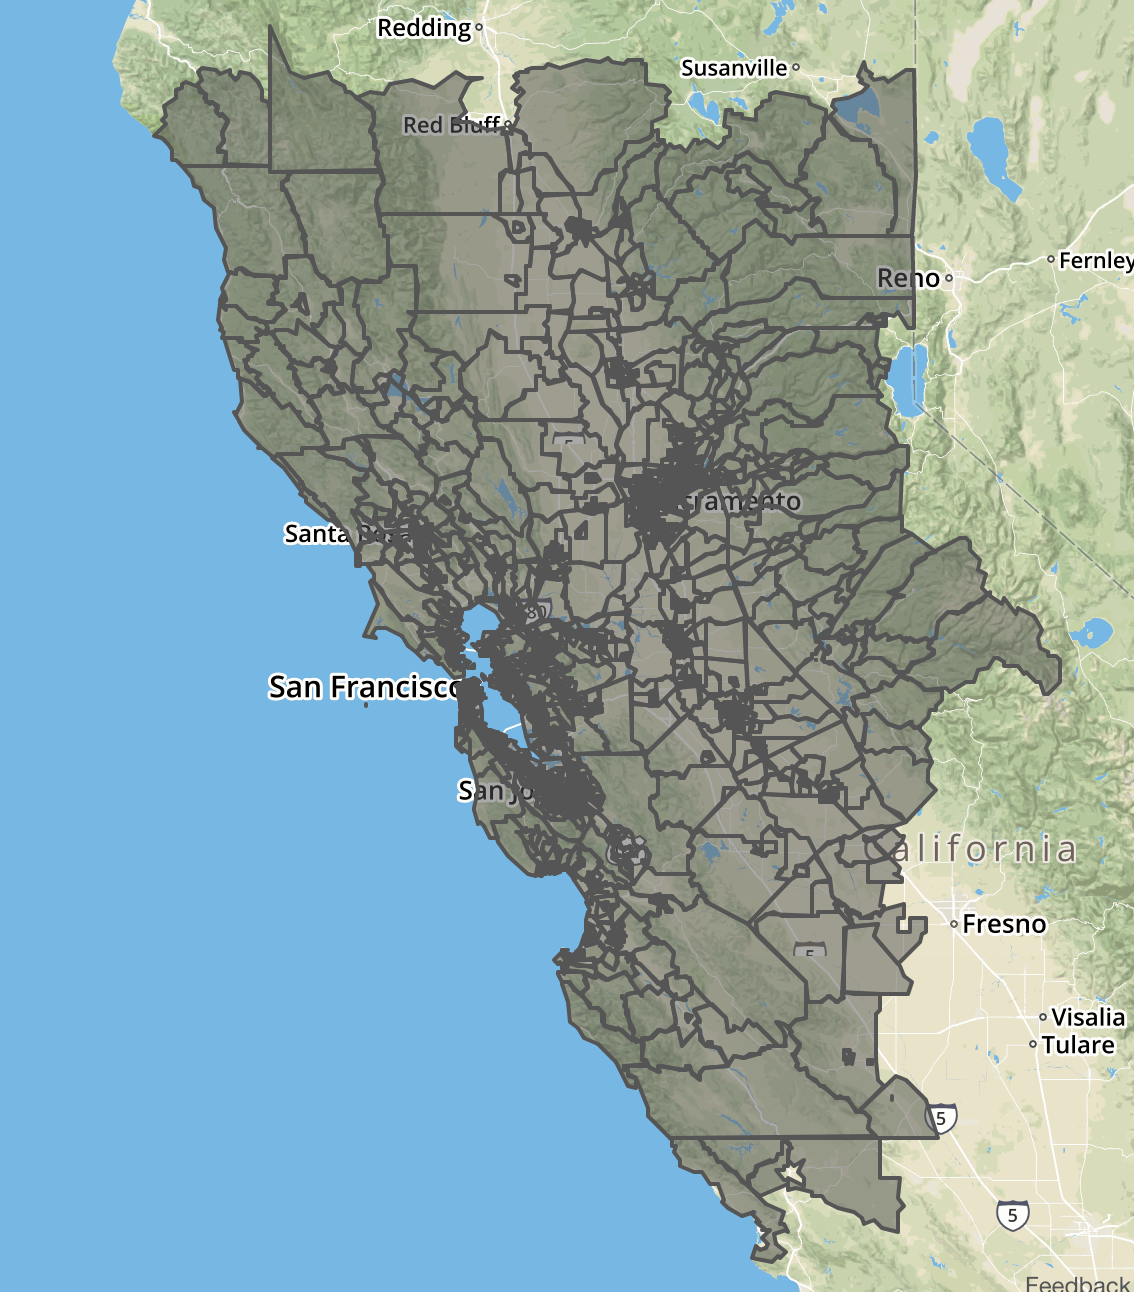

In [93]:
Image('assets/uber_census_tracts.png', width=300)

The first preprocessing step was therefore to filter the data to San Francisco - see appendix B for the complete code. We did this by first drawing a bounding box around San Francisco using this webpage: https://boundingbox.klokantech.com/. We started by filtering the Uber zones to be inside of that bounding box.

In [94]:
features = zones['features']
sf_features = list(filter(feature_in_bbox, features))
sf_zones = {
    'type': 'FeatureCollection',
    'features': list(map(parse_feature, sf_features)),
}
print(f'#features = {len(features)}')
print(f'#San Francisco features = {len(sf_features)}')

#features = 2710
#San Francisco features = 194


This filtering significantly reduced the amount of zones from 2710 to 194. This was important since we needed to compare travel times between pairs of zones. With 194 zones we had up to $194^2 = 37,636$ pairs which is a manageable number of pairs in contrast to $2710^2 = 7,344,100$ which would require too much processing to be feasible to show in an observable notebook.

Now that the zones had been constrained to San Francisco, we were able to filter the two Uber datasets to only contain zone pairs in San Francisco.

In [95]:
sf_zone_ids = [zone['properties']['id'] for zone in sf_zones['features']]

In [96]:
uber_in_sf_dow = uber_dow[uber_dow['sourceid'].isin(sf_zone_ids) & uber_dow['dstid'].isin(sf_zone_ids)]
print(f'#Uber (Day of week) zone pairs: {len(uber_dow)}')
print(f'#Uber (Day of week) in San Francisco zone pairs: {len(uber_in_sf_dow)}')

#Uber (Day of week) zone pairs: 3809802
#Uber (Day of week) in San Francisco zone pairs: 259529


In [97]:
uber_in_sf_hod = uber_hod[uber_hod['sourceid'].isin(sf_zone_ids) & uber_hod['dstid'].isin(sf_zone_ids)]
print(f'#Uber (Hour of day) zone pairs: {len(uber_hod)}')
print(f'#Uber (Hour of day) in San Francisco zone pairs: {len(uber_in_sf_hod)}')

#Uber (Hour of day) zone pairs: 10241570
#Uber (Hour of day) in San Francisco zone pairs: 847148


This was all of the preprocessing we needed to do for the Uber datasets since these datasets were already cleaned and aggregated by Uber.

Next we had to filter the Ford GoBike dataset to be constrained to the San Francisco bounding box.

In [98]:
bikes_selected = bikes.apply(bike_trip_is_in_sf, axis=1)
bikes_in_sf = bikes[bikes_selected].copy()
print(f'#bike trips = {len(bikes)}')
print(f'#San Francisco bike trips = {len(bikes_in_sf)}')

#bike trips = 312902
#San Francisco bike trips = 233022


We see that most of the bike trips were already happening in San Francisco but the filtering did still remove a noticeable amount of bike trips.

## 3.3. Bike Trip Exclusions

The goal of this work involves travel times between zones. We were therefore not interesed in bike trips where the user had stopped along the way for a break or where the user had used the bike to return to the same location. The next step in the filtering was therefore to remove bike trips that contained breaks or started and ended close to the same location (return trips). We had to estimate the distance travelled in order to filter on both criteria: Filtering for breaks required information on the speed which depended on the distance and duration. Filtering for returns trips required information on the distance travelled. We estimated the distance travelled by computing the geodesic distance[3] between the start and end stations. See appendix C for the code.

In [99]:
bikes_in_sf['distance'] = bikes_in_sf.apply(get_row_distance, axis=1)

Now that the distance had been estimated, we used it to estimate the average speed of the trip.

In [100]:
bikes_in_sf['speed'] = get_speed(bikes_in_sf)

This enabled us to filter the dataset to exclude trips with speeds lower than 3.5 km/h since we considered those trips to contain breaks. This was a reasonable assumption given that you can easily walk faster than 3.5 km/h. Furthermore, the following plot of the speed distribution also shows that speeds lower than 3.5 km/h probably contains breaks.

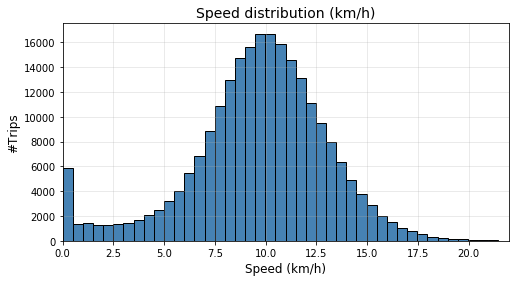

In [101]:
plt.figure(figsize=(8, 4))
plt.grid(alpha=0.33)
plt.hist(bikes_in_sf['speed'], bins=50, edgecolor='black', facecolor='steelblue')
plt.xlim(0, 22)
plt.title('Speed distribution (km/h)', fontsize=14)
plt.xlabel('Speed (km/h)', fontsize=12)
plt.ylabel('#Trips', fontsize=12)
plt.show()

The speed distribution shows that there are over 6000 outliers in the sense that they have speeds close to 0 km/h. It also shows that most of the remaining speeds are above 3.5. This supports our reasoning that it is reasonable to consider trips with speeds lower than 3.5 km/h to contain breaks.

In [102]:
bikes_no_breaks = bikes_in_sf[bikes_in_sf['speed'] > 3.5]
print(f'#San Francisco bike trips = {len(bikes_in_sf)}')
print(f'#San Francisco bike trips without breaks = {len(bikes_no_breaks)}')

#San Francisco bike trips = 233022
#San Francisco bike trips without breaks = 218980


We define a return trip as a trip that starts and ends 0.1 km within each other. Notice that we don't set the distance between start- and end location to 0 km since we suspect that some users may not always return to the exact same station. This could for example be the case if you need to do the groceries on your way home and therefore return the bike close to the shop.

In [103]:
bikes_single_trip = bikes_no_breaks[bikes_no_breaks['distance'] > 0.1]
print(f'#San Francisco bike trips without breaks = {len(bikes_no_breaks)}')
print(f'#San Francisco bike single trips without breaks = {len(bikes_single_trip)}')

#San Francisco bike trips without breaks = 218980
#San Francisco bike single trips without breaks = 218980


# 3.4 Matching Bike Stations (Points) With Zones (Polygons)

After having filtered the datasets to San Francisco and excluded bike trips with breaks and trips that are return trips, we had to address the challenge of making the datasets comparable. The challenge consisted of the fact that the Uber datasets were referencing zones (polygons) and the Ford GoBike dataset was referincing stations (points). Therefore we would have to find a method to determine which zones contained which stations. In mathematical terms we had to find the set of points that each polygon was intersecting with. In order to do this we needed an algorithm to determine if a point was inside of a polygon. We found ray casting[4] useful for this purpose and the implementation can be seen in appendix D.

The first step to match stations and zones was to create a table of all the stations in the Ford GoBike dataset (see appendix C).

In [104]:
stations = get_stations(bikes_single_trip)

Once we had the table of stations, we could use it to map stations to zones. Note that this is a 1-to-1 mapping since a point can only reside inside of one polygon when none of the polygons are overlapping.

In [105]:
station2zone = {}
station_ids = stations.id
for station_id in station_ids:
    row = stations[stations.id == station_id].iloc[0]
    zone_id = find_zone(row.latitude, row.longitude)
    station2zone[station_id] = zone_id

The station to zone map would then enable us to extend the Ford GoBike dataset with start- and end zones:

In [106]:
bikes_with_zones = bikes_single_trip.copy()
bikes_with_zones['start_zone'] = bikes_with_zones.apply(lambda x: station2zone[x.start_station_id], axis=1)
bikes_with_zones['end_zone'] = bikes_with_zones.apply(lambda x: station2zone[x.end_station_id], axis=1)

At this point we had succeeded in making durations in the Ford GoBike dataset comparable with the durations in the Uber datasets.

## 3.5 Aggregating Bike Data

The final preprocessing steps were to group the Ford GoBike dataset by hour of day and day of week in order to match the structure of the averaged Uber datasets. First we extended the Ford GoBike dataset with a transformed date feature. The code for this can be seen in appendix C.

In [107]:
bikes_with_zones['start_date'] = get_start_date(bikes_with_zones)

The extension with a parsed starting date allowed us to directly extract the hour of the day and the day of the week from this feature.

In [108]:
bikes_with_zones['hour_of_day'] = bikes_with_zones.start_date.dt.hour
bikes_with_zones['day_of_week'] = bikes_with_zones.start_date.dt.dayofweek
bikes_with_zones['day_of_week'] = day_number_to_name(bikes_with_zones)

This would then enable us to group by hour of day and day of week such that the Ford GoBike dataset would match the structure of the Uber datasets.

In [109]:
bikes_hod = bikes_with_zones[station_hod_cols].groupby(station_hod_cols[:-1]).mean()
bikes_hod.head()

duration_sec
hour_of_day start_zone end_zone              
0           80         80               225.5
                       113              555.0
                       212             1235.0
                       1246             605.0
            113        537              312.0

In [110]:
bikes_dow = bikes_with_zones[station_dow_cols].groupby(station_dow_cols[:-1]).mean()
bikes_dow.head()

duration_sec
day_of_week start_zone end_zone              
Monday      80         80          208.222222
                       113         362.500000
                       206         734.300000
                       207                NaN
                       208        1341.500000

It is worth noting that the NaN value from zone 80 to zone 207 means that there were no trips between those two zones in the filtered Ford GoBike dataset.

This concludes our preprocessing of the datasets.

# 4. Data Analysis

In this section we will present some interesting distributions about the dataset. Note, however, that we will only do so briefly since a huge part of the data analysis consisted of preprocessing the datasets as described in section 3.

Let us first look at the distribution of travel times for the Ford GoBike and the combined Uber datasets.

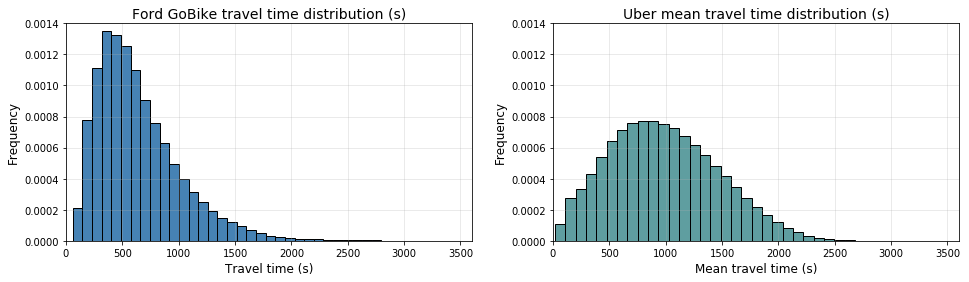

In [117]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.grid(alpha=0.33)
plt.hist(bikes_single_trip['duration_sec'], bins=60, edgecolor='black', facecolor='steelblue', density=True)
plt.title('Ford GoBike travel time distribution (s)', fontsize=14)
plt.xlabel('Travel time (s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 3600)
plt.ylim(0, 0.0014)

plt.subplot(1, 2, 2)
uber = uber_in_sf_dow.append(uber_in_sf_hod, ignore_index=True, sort=False)
plt.grid(alpha=0.33)
plt.hist(uber['mean_travel_time'], bins=36, edgecolor='black', facecolor='cadetblue', density=True)
plt.title('Uber mean travel time distribution (s)', fontsize=14)
plt.xlabel('Mean travel time (s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 3600)
plt.ylim(0, 0.0014)

plt.show()

The comparison of these two distributions shows that bike users tend to travel for a shorter duration. Notice that this does not give any information about which is fastest since we are only looking at the duration and are not considering the distance travelled. What we can say from this comparison is that it is likely that bikes will not be travelling far while it is more likely that we will see more cases of cars travelling relatively large distances since they tend to travel for longer times. Alternatively, it could be that the cars are stuck in traffic which could also cause the tendency of longer travel times.

Next we will look at the average travel time conditioned on the hour of the day for the Ford GoBike dataset and the Uber dataset averaged over the hour of day.

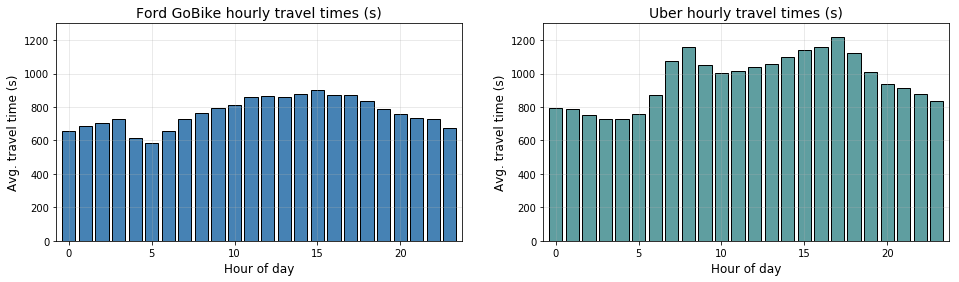

In [112]:
plt.figure(figsize=(16, 4))
hours = list(range(24))

plt.subplot(1, 2, 1)
bikes_duration_hod = bikes_hod.groupby('hour_of_day').duration_sec.mean()
plt.grid(alpha=0.33)
plt.bar(hours, bikes_duration_hod, edgecolor='black', facecolor='steelblue')
plt.title('Ford GoBike hourly travel times (s)', fontsize=14)
plt.xlabel('Hour of day', fontsize=12)
plt.ylabel('Avg. travel time (s)', fontsize=12)
plt.xlim(-0.75, 23.75)
plt.ylim(0, 1300)

plt.subplot(1, 2, 2)
uber_duration_hod = uber_in_sf_hod.groupby('hod').mean_travel_time.mean()
plt.grid(alpha=0.33)
plt.bar(hours, uber_duration_hod, edgecolor='black', facecolor='cadetblue')
plt.title('Uber hourly travel times (s)', fontsize=14)
plt.xlabel('Hour of day', fontsize=12)
plt.ylabel('Avg. travel time (s)', fontsize=12)
plt.xlim(-0.75, 23.75)
plt.ylim(0, 1300)

plt.show()

These distributions have some interesting peaks and valleys. First we see that the Uber dataset has peaks around 8 am and again around 5 pm. These peaks match well with the times that people get to and from work and therefore match our expectations of when one is most likely to get stuck in traffic. Similarly, it seems that it is easy to get around in a car during the night since the average travel time is relatively low. The Ford GoBike dataset also has a noticeable difference between day and night travelling times but there is an outlier around 1-3 am. Apparently bike travel times are a bit longer around 1-3 am than they are during the rest of the night. We have not been able to find a reason for why this can be observed. Perhaps it could be because drunk people try to get home at those hours and because of their drunken state tend to travel more slowly.

An important aspect that we see from the comparison of these two distributions is that the difference between bike and car travel times vary across the day and so it is important to allow the reader to condition the displayed data on the hour of the day in our observable notebook. This can be seen more clearly in the bar plot below where the bars above 0 are the hours where bikes travel for the shortest duration on average and the bars below 0 would - if there had been any - show the hours when cars travel for the shortest duration on average.

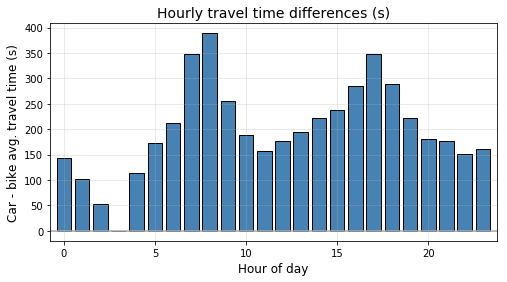

In [113]:
plt.figure(figsize=(8, 4))
hours = np.arange(24)
difference = uber_duration_hod - bikes_duration_hod
positive = 0 <= difference
negative = difference < 0
plt.grid(alpha=0.33)
plt.hlines(0, -0.75, 23.75, colors='darkgray')
plt.bar(hours[positive], difference[positive], edgecolor='black', facecolor='steelblue')
plt.bar(hours[negative], difference[negative], edgecolor='black', facecolor='cadetblue')
plt.title('Hourly travel time differences (s)', fontsize=14)
plt.xlabel('Hour of day', fontsize=12)
plt.ylabel('Car - bike avg. travel time (s)', fontsize=12)
plt.xlim(-0.75, 23.75)
plt.show()

This plot makes it clear that the car travel time is significantly higher than the bike travel time during rush hours.

Finally we will look at how the average travel time is distributed conditioned on the day of the week. This can been seen in the bar plot below where the Ford GoBike dataset is plotted on the left and the Uber dataset averaged over the day of the week is plotted on the right.

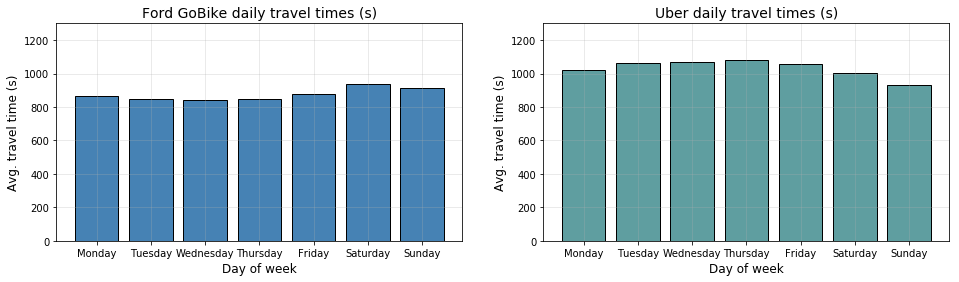

In [114]:
plt.figure(figsize=(16, 4))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.subplot(1, 2, 1)
bikes_duration_dow = bikes_dow.groupby('day_of_week').duration_sec.mean()
plt.grid(alpha=0.33)
plt.bar(days, bikes_duration_dow, edgecolor='black', facecolor='steelblue')
plt.title('Ford GoBike daily travel times (s)', fontsize=14)
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Avg. travel time (s)', fontsize=12)
plt.ylim(0, 1300)

plt.subplot(1, 2, 2)
uber_duration_dow = uber_in_sf_dow.groupby('dow').mean_travel_time.mean()
plt.grid(alpha=0.33)
plt.bar(days, uber_duration_dow, edgecolor='black', facecolor='cadetblue')
plt.title('Uber daily travel times (s)', fontsize=14)
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Avg. travel time (s)', fontsize=12)
plt.ylim(0, 1300)

plt.show()

Interestingly it appears that the bike and car average travel times are close to each other at roughly 900-1000 seconds when conditioning on the day of the week. This is somewhat surprising considering that we previously saw greater differences when conditioning on the hour of the day. There is still a difference in how the travel time is distributed on weekdays and weekends. The Ford GoBike dataset shows that bike users travel for longer on weekends than on weeekdays while the Uber dataset shows the opposite relation between weekdays and weekends. We have not been able to discover why this difference is happening but it does show that it will be relevant to enable the reader to condition on the day of the week in the observable notebook.

# 5. Genre

We chose to use magazine style as the genre for our visualization. The reasoning for this was firstly that the visualization (see section 6) would display a lot of data in a single frame. The single frame is a key characteristic of the magazine style which made it a good fit. Secondly, an important aspect of the magazine style genre is that it allows for a textual story to be written around the visualization. This gave the opportunity to ease the reader into the story and so be guided into understanding the visualization.

The tools that we used from Figure 7 in Segal and Heer[5] can be seen in the following two lists. We explain how each tool was used next to each item in the lists. The first list contains the visual narratives that were used in our visualization:

* **Consistent Visual Platform**: Providing the same structure, scale, and color across different filters makes it possible to compare different filterings and is essential in making the visualization succeed.

* **Feature Distinction**: It is important to inform the reader about which zone has been selected. This is done by distinguishing the selected zone using a different background and border color.

The list of visual structure tools is a bit short. This is because a lot of the visual structure tools are not applicable in the magazine style genre. For example, most of the transition guidance tools are not applicable since many of these tools are related to cameras. Below you can find the list of narrative structure tools that were used:

* **Random Access**: The visualization contains many combinations of times and starting zones. The large amount of combinations means that the readers should (eventually) be given random access to the different settings and so explore the data visualization for themselves. This is also a feasible option given that the accompanying article introduces the user to the story and the visualization.

* **Hover Highlighting / Details**: The colored map makes it easy to get an overview of the travel times on the map. However, it does not make it easy to see the exact average travel times between zones. This is addressed by showing details when hovering a zone.

* **Filtering / Selection / Search**: As stated in section 4, it is relevant to allow the reader to filter based on the hour of the day and the day of the week. This is implemented as a slider ranging from 0 to 23 (the hour of the day) and as a dropdown menu of the days in a week. The reader is also given the option to filter based on the zone to start from. This is done by clicking on the zone that the reader wants to view travel times from.

* **Stimulating Default Views**: Some views are less interesting than others and therefore we engage the reader by letting the reader start by viewing a comparison of bike and car travel times from Mission District during rush hour.

* **Captions / Headlines**: This tool is used as part of the accompanying article but is not used in the visualization itself.

* **Accompanying Article**: A common part of the magazine style genre is the accompanying article. We included an accompanying article as a way to ease the reader in to understanding the visualization.

# 6. Visualizations

As previously stated, we want to investigate under which circumstances cars are faster than bikes and vice versa in cities. Our datasets provide information related to this goal in the context of San Francisco. Therefore it makes sense for our visualization to show travel times on a map of San Francisco. In order to get a complete picture of the circumstances, the visualization must allow for some interactivity. The datasets contain contextual information about start- and end location and when the trip happened. This information is relevant in understanding the circumstances in which transportation device is faster and the visualization should allow filtering based on this information.

Based on the requirements above, we have found the following visualization to be the most optimal to achieve the goal: An interactive choropleth map of San Francisco where San Francisco is divided into zones as specified by the census tract zones from the Uber datasets[2]. The user is able to click on a zone to get information on how long it takes to travel from that zone to other zones. This information is conveyed by filling each zone with color where darker colors means longer travel times. The user can further filter the dataset by looking at either a specific day of the week or at a specific hour of the day. Finally the user must be able to choose to either view travel times for bikes, cars or the difference between the two.

The visualization we have chosen is simple yet powerful. It fulfills all of the abovementioned requirements and manages to convey a lot of information in a meaningful way to the goal. These are the reasons that we think this visualization is the right visualization to tell the story of when cars or bikes are faster.

# 7. Discussion

We have gained insights into what went well and why from having created the visualization and the accompanying article. In this section we will discuss what went well and why as well as discussing the things that did not go well and how they can be improved. We will start with the things that went well:

The first thing that went well is the merging of zones and stations. This was a necessary preprocessing step that could have been hard to debug if it had not gone well. Fortunately it worked perfectly which made the visualization possible. We also found that the choice of visualization worked very well. This can be seen from how it manages to present many different configurations in a single frame while still being fairly easy to understand. This has been achieved by using the tools discussed in section 6. The choice of visualization also worked well because it enabled us to achieve the goal of this work - "to investigate the circumstances in cities in which cars are faster than bikes and vice versa".

In regard to what could have been better, we find that the Ford GoBike dataset could have covered much more of San Francisco. The Ford GoBike dataset only covered about a fourth of San Francisco while the Uber datasets covered all of San Francisco. This resulted in the comparison being restricted to a small part of the city. As discussed in the previous paragraph, the choice of visualization worked well in fulfilling the goal of comparing car and bike travel times. Therefore we find that this analysis should be performed again if Ford GoBike manages to expand to all of San Francisco. Another thing that could have been improved upon is the performance of the data transformation scripts in the observable notebook. These scripts are implemented in a naive way which results in it taking several seconds for the visualization to load. The long loading is acceptable since the reader is first presented with an article which gives time for the visualization to load. However, the user experience should still be improved by improving the performance of the data transformation scripts.

# 8. Contributions

We wrote the accompanying article together but the rest of the work was mainly divided as it can be seen in the following table.

**Christoffer Øhrstrøm (s182827)**                     | **Péter Gönczöl (s172439)**
-------------------------------------------------------|-----------------------------------------------------------------------------------
Filtering of data to San Francisco                     | Discovery of datasets
Ray casting                                            | Generating bike hour of day and day of week data from filtered Ford GoBike dataset
Explainer notebook                                     | Controls in observable notebook 
Data loading and transformation in observable notebook | Map with interactivity in observable notebook
Map without interactivity in observable notebook       |

# 9. Acknowledgements

Data retrieved from Uber Movement, (c) 2019 Uber Technologies, Inc., https://movement.uber.com.

# 10. References

[1] Ford GoBike, Ford GoBike trip history data, https://www.fordgobike.com/system-data, Accessed on: 2019-05-03.

[2] Uber, Uber Movement Travel Times San Francisco, https://movement.uber.com/explore/san_francisco/travel-times, Accessed on: 2019-05-03.

[3] R. Kimmel and J. A. Sethian. Computing Geodesic Paths on Manifolds in the Proceedings of National Academy of Sciences, 95(15):8431–8435, July, 1998.

[4] Shimrat, M., "Algorithm 112: Position of point relative to polygon" 1962, Communications of the ACM Volume 5 Issue 8, Aug. 1962.

[5] E. Segel and J Heer, "Narrative Visualization: Telling Stories with Data", Oct, 2010.

# Appendix

All of the following appendices contain the code used to load and process the data presented in this notebook. First we import the libraries needed to do the loading and processing. The libraries are then used in the following appendices.

In [62]:
%matplotlib inline
from collections import namedtuple
from datetime import datetime
import geopy.distance
from IPython.display import Image
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## A. Load Datasets

In [63]:
bikes = pd.read_csv('data/unprocessed/bikes_2018_q1.csv')

In [64]:
uber_dow = pd.read_csv('data/unprocessed/uber_2018_q1_day_of_week.csv')

In [65]:
uber_hod = pd.read_csv('data/unprocessed/uber_2018_q1_hour_of_day.csv')

In [66]:
with open('data/unprocessed/sf_censustracts.json', 'r') as f:
    zones = json.load(f)

## B. Filtering To San Francisco

In [67]:
SF_BBOX = {
    'lat_lower': 37.707478057,
    'lon_lower': -122.530028796,
    'lat_upper': 37.8121422174,
    'lon_upper': -122.3538465925,
}

In [68]:
def in_bbox(coordinates):
    longtitude, lattitude = coordinates
    return (
        SF_BBOX['lat_lower'] < lattitude and lattitude < SF_BBOX['lat_upper'] and
        SF_BBOX['lon_lower'] < longtitude and longtitude < SF_BBOX['lon_upper']
    )

In [69]:
def feature_in_bbox(feature):
    multi_polygon = feature['geometry']['coordinates']
    # don't include Treasure Island (id=1695)
    if feature['properties']['MOVEMENT_ID'] == '1695':
        return False
    for polygon in multi_polygon:
        exterior_ring = polygon[0]
        contained_in_sf = map(in_bbox, exterior_ring)
        if all(contained_in_sf):
            return True
    return False

In [70]:
def parse_feature(feature):
    properties = feature['properties']
    return {
        'geometry': feature['geometry'],
        'properties': {
            'name': properties['DISPLAY_NAME'],
            'id': int(properties['MOVEMENT_ID']),
        },
        'type': 'Feature',
    }

In [71]:
def bike_trip_is_in_sf(row):
    return (
        in_bbox([row['start_station_longitude'], row['start_station_latitude']]) and
        in_bbox([row['end_station_longitude'], row['end_station_latitude']])
   )

## C. Ford GoBike: Feature Extraction

In [72]:
def get_row_distance(row):
    start = (row['start_station_latitude'], row['start_station_longitude'])
    end = (row['end_station_latitude'], row['end_station_longitude'])
    return geopy.distance.distance(start, end).km

In [73]:
def get_speed(data):
    return data['distance'] / data['duration_sec'] * 3600

In [74]:
def get_stations(data):
    stations = pd.DataFrame(columns=['id', 'latitude', 'longitude'])

    start_bikes_latitudes = data.groupby('start_station_id').start_station_latitude.unique()
    start_bikes_longitudes = data.groupby('start_station_id').start_station_longitude.unique()
    start_station_ids = start_bikes_latitudes.index
    for i, station_id in enumerate(start_station_ids):
        station_id = int(station_id)
        stations.loc[i] = [station_id, start_bikes_latitudes[station_id][0], start_bikes_longitudes[station_id][0]]

    end_bikes_latitudes = data.groupby('end_station_id').end_station_latitude.unique()
    end_bikes_longitudes = data.groupby('end_station_id').end_station_longitude.unique()
    end_station_ids = end_bikes_latitudes.index
    for i, station_id in enumerate(end_station_ids):
        station_id = int(station_id)
        stations.loc[i] = [station_id, end_bikes_latitudes[station_id][0], end_bikes_longitudes[station_id][0]]

    stations['id'] = stations['id'].astype('int')
    return stations

In [75]:
def get_start_date(data):
    return data.apply(lambda x: datetime.strptime(x.start_time, '%Y-%m-%d %H:%M:%S.%f'), axis=1)

In [76]:
def day_number_to_name(data):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_type = pd.CategoricalDtype(days, ordered=True)
    return data.apply(lambda x: days[x.day_of_week], axis=1).astype(days_type)

In [77]:
station_cols = ['start_zone', 'end_zone', 'duration_sec']
station_dow_cols = ['day_of_week'] + station_cols
station_hod_cols = ['hour_of_day'] + station_cols

## D. Ray Casting

In [78]:
Pt = namedtuple('Pt', 'x, y')                 # Point
Edge = namedtuple('Edge', 'a, b')             # Polygon edge from a to b
Equation = namedtuple('Equation', 'a, b, c')  # Equation of a line
_epsilon = 0.0000001                          # Threshold at which to compare numbers for equality

In [79]:
def _get_line_equation(edge):
    a = edge.b.y - edge.a.y
    b = edge.a.x - edge.b.x
    c = (edge.b.x * edge.a.y) - (edge.a.x * edge.b.y)
    return Equation(a=a, b=b, c=c)

In [80]:
def _check_line_equation(equation, point):
    return equation.a * point.x + equation.b * point.y + equation.c

In [81]:
def _has_same_sign(n1, n2):
    return (n1 > 0 and n2 > 0) or (n1 < 0 and n2 < 0)

In [82]:
def _equals(n1, n2):
    return abs(n1 - n2) <= _epsilon

In [83]:
def _ray_intersects_edge(ray, edge):
    """
    Takes a point p = Pt() and an edge of two endpoints a, b = Pt() of a line segment and returns a boolean
    """

    # convert ray to a line of infinite length (so it satisfies a1 * x + b1 * y + c1 = 0 for all (x,y) on the line)
    ray_line = _get_line_equation(ray)
    ray_d1 = _check_line_equation(ray_line, edge.a)
    ray_d2 = _check_line_equation(ray_line, edge.b)

    # if d1 and d2 have the same sign, then both endpoints of edge are on the same side of the ray line
    if _has_same_sign(ray_d1, ray_d2):
        return False

    edge_line = _get_line_equation(edge)
    edge_d1 = _check_line_equation(edge_line, ray.a)
    edge_d2 = _check_line_equation(edge_line, ray.b)
    if _has_same_sign(edge_d1, edge_d2):
        return False

    # either vectors intersects at excactly one point or they are colinear
    return not _equals((ray_line.a * edge_line.b) - (ray_line.b * edge_line.a), 0)

In [84]:
def _point_intersects_polygon(point):
    def intersects_polygon(polygon):
        if len(polygon) < 2:
            return False
        xs = list(map(lambda edge: edge.a.x, polygon))
        min_x = min(xs)
        ray_a = Pt(x=min_x, y=point.y)
        ray_b = point
        ray = Edge(a=ray_a, b=ray_b)
        intersections = 0
        for edge in polygon:
            if _ray_intersects_edge(ray, edge):
                intersections += 1
        return intersections % 2 == 1
    return intersects_polygon

In [85]:
def _ring2edges(ring):
    """
    Transforms a ring into a list of edges.
    Assumes that the ring starts and ends at the same coordinate.
    """
    edges = []
    for i in range(len(ring) - 1):
        lon1, lat1 = ring[i]
        lon2, lat2 = ring[i + 1]
        a = Pt(x=lon1, y=lat1)
        b = Pt(x=lon2, y=lat2)
        edge = Edge(a=a, b=b)
        edges.append(edge)
    return edges

In [86]:
def point_intersects_multi_polygon(point, multi_polygon):
    lon, lat = point
    point = Pt(x=lon, y=lat)
    intersects = _point_intersects_polygon(point)
    for polygon in multi_polygon:
        exterior_ring = _ring2edges(polygon[0])
        interior_rings = list(map(_ring2edges, polygon[1:]))
        intersects_exterior = intersects(exterior_ring)
        intersects_interior = any(map(intersects, interior_rings))
        if intersects_exterior and not intersects_interior:
            return True
    return False

In [87]:
class ZoneNotFoundException(Exception):
    pass

In [88]:
def find_zone(latitude, longitude):
    point = (longitude, latitude)
    for zone in sf_zones['features']:
        multi_polygon = zone['geometry']['coordinates']
        if point_intersects_multi_polygon(point, multi_polygon):
            return zone['properties']['id']
    raise ZoneNotFoundException

In [89]:
def find_stations(zone):
    multi_polygon = zone['geometry']['coordinates']
    zone_stations = []
    for _, station in stations.iterrows():
        point = (station.longitude, station.latitude)
        if point_intersects_multi_polygon(point, multi_polygon):
            zone_stations.append(int(station.id))
    return zone_stations